In [1]:
import pandas as pd
import random
import json
import os
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
df = pd.read_csv('db/comments_for_Arco.csv')

In [3]:
df.sectorName = df['sectorName'].str.lower()
df.cragName = df['cragName'].str.lower()
df.areaName = df['areaName'].str.lower()
df.zlaggableName = df['zlaggableName'].str.lower()

In [4]:
df = df[~df.cragName.isin(['valgua', 'corte'])]

In [5]:
df = df.drop_duplicates(subset=['userSlug', 'date', 'cragName', 'sectorName', 'zlaggableName', 'comment'], keep='last')
len(df)

53763

In [6]:
df = df.dropna(subset=['userSlug'])
len(df)

46506

In [7]:
dic_crags = {}
for crag in df.cragName.unique():
    dic_crags[crag] = crag

In [8]:
dic_crags['corno di bò'] = 'corno di bo'
dic_crags['al prà'] = 'al pra'
dic_crags['maso limarò'] = 'maso limaro'

In [9]:
df = df.replace({"cragName": dic_crags})

In [10]:
df = df.drop_duplicates(subset=['userSlug', 'date', 'cragName'], keep='last')

In [11]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [12]:
df = df[df['date'].dt.date > pd.Timestamp(2008,1,1)]
df = df.sort_values(by="date")

In [13]:
dic_users_visits = {}
dic_users_crags = {}
for each_line in df.index:
    user_slug = df.loc[each_line, 'userSlug']
    cragName = df.loc[each_line, 'cragName']
    if user_slug in dic_users_visits.keys():
        if cragName not in dic_users_crags[user_slug]:
            dic_users_visits[user_slug] += 1
            dic_users_crags[user_slug].append(cragName)
    else:
        dic_users_visits[user_slug] = 1
        dic_users_crags[user_slug] = [cragName]
            
users_with_more_than_five_crags = []
users_with_more_than_three_crags = []
users_with_more_than_ten_crags = []
users_with_more_than_twenty_crags = []
for user_slug in df.userSlug.unique():
    if dic_users_visits[user_slug] >= 3:
        users_with_more_than_three_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 5:
        users_with_more_than_five_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 10:
        users_with_more_than_ten_crags.append(user_slug)
    if dic_users_visits[user_slug] >= 20:
        users_with_more_than_twenty_crags.append(user_slug)

In [14]:
print('three:', len(users_with_more_than_three_crags))
print('five:', len(users_with_more_than_five_crags))
print('ten:', len(users_with_more_than_ten_crags))
print('twenty:', len(users_with_more_than_twenty_crags))
print('unique users:', len(df.userSlug.unique()))

three: 1502
five: 746
ten: 228
twenty: 55
unique users: 3291


In [15]:
df = df[df.userSlug.isin(users_with_more_than_five_crags)]

In [16]:
len(df.cragName.unique())

107

In [17]:
users_num_full = len(df.userSlug.unique())
crags_num_full = len(df.cragName.unique())

crag_visits_per_user = np.zeros((users_num_full, crags_num_full))
ui_rating = np.zeros((users_num_full, crags_num_full))
num_rating = np.zeros((users_num_full, crags_num_full))
crag_visits = np.zeros(crags_num_full)
unique_crag_visits = np.zeros(crags_num_full)

In [18]:
dic_users_full = {}
dic_users_reverse_full = {}
i = 0
for userSlug in sorted(df.userSlug.unique()):
    dic_users_full[userSlug] = i
    dic_users_reverse_full[i] = userSlug
    i += 1

In [19]:
dic_crags_id_full = {}
dic_crags_id_reverse_full = {}
i = 0
for cragName in sorted(df.cragName.unique()):
    dic_crags_id_full[cragName] = i
    dic_crags_id_reverse_full[i] = cragName
    i += 1

In [20]:
crags_visited_by_user = {}
for userSlug in df.userSlug.unique():
    user_id = dic_users_full[userSlug]
    crags_visited_by_user[user_id] = []
for each_line in df.index:
    userSlug = df.loc[each_line, 'userSlug']
    cragName = df.loc[each_line, 'cragName']
    rating = np.round(df.loc[each_line, 'rating'])
    crag_id = dic_crags_id_full[cragName]
    user_id = dic_users_full[userSlug]
    if crag_id not in crags_visited_by_user[user_id]:
        crags_visited_by_user[user_id].append(crag_id)

    if rating > 0:
        ui_rating[user_id, crag_id] += rating
        num_rating[user_id, crag_id] += 1
    crag_visits_per_user[user_id, crag_id] += 1

In [21]:
for each_line in df.index:
    userSlug = df.loc[each_line, 'userSlug']
    cragName = df.loc[each_line, 'cragName']
    crag_id = dic_crags_id_full[cragName]
    user_id = dic_users_full[userSlug]
    if num_rating[user_id, crag_id] > 0:
        ui_rating[user_id, crag_id] = ui_rating[user_id, crag_id]/num_rating[user_id, crag_id]

In [22]:
for userSlug in df.userSlug.unique():
    user_id = dic_users_full[userSlug]
    for cragName in df.cragName.unique():
        crag_id = dic_crags_id_full[cragName]
        if crag_visits_per_user[user_id, crag_id] > 5:
            crag_visits_per_user[user_id, crag_id] = 5

In [23]:
for userSlug in df.userSlug.unique():
    user_id = dic_users_full[userSlug]
    for cragName in df.cragName.unique():
        crag_id = dic_crags_id_full[cragName]
        crag_visits[crag_id] += crag_visits_per_user[user_id, crag_id]
        if crag_visits_per_user[user_id, crag_id]>0:
            unique_crag_visits[crag_id] += 1

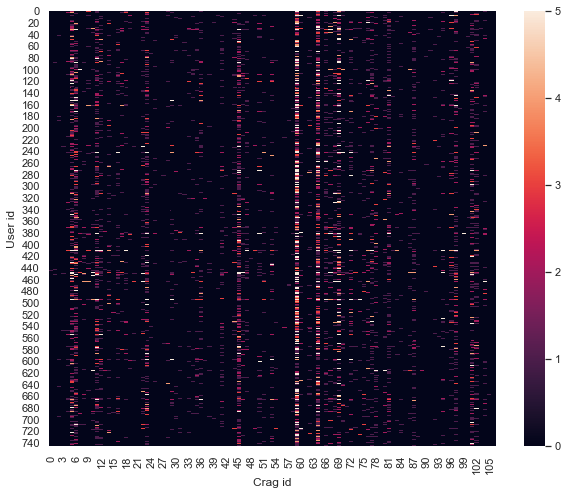

In [24]:
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.heatmap(crag_visits_per_user)
ax.set(xlabel='Crag id', ylabel='User id')
plt.show()
plt.show()

# Crags content

In [25]:
crags_content = pd.read_csv('db/crags_features.csv', header=0, delimiter=';')
crags_content = crags_content.fillna(0)
crags_content['id'] = crags_content['Name crag']

In [26]:
crags_content = crags_content.replace({"id": dic_crags_id_full})
crags_content = crags_content[crags_content['Name crag'].isin(df.cragName.unique())]

In [27]:
crags_content['unique'] = crags_content['id']

In [28]:
for ind in crags_content.index:
    crags_content.loc[ind, 'unique'] = unique_crag_visits[crags_content.loc[ind, 'id']]

In [29]:
crags_content['unique'] = pd.to_numeric(crags_content['unique'])
crags_content['rating'] = pd.to_numeric(crags_content['rating'])

In [30]:
crags_content.head()

Name crag  #Routes   sum  approach, min    N    E    S    W   Ja   Fe  \
0       acheni      7.0   7.0              5  1.0  0.0  0.0  0.0  0.0  0.0   
1       al pra     54.0  54.0             15  0.0  1.0  0.0  1.0  0.0  0.0   
2  arcadioland     19.0  19.0             15  0.0  1.0  1.0  0.0  0.0  0.0   
3        athos     14.0  14.0             20  0.0  1.0  1.0  0.0  0.0  0.0   
4    babilonia     18.0  18.0             15  0.0  1.0  1.0  0.0  0.0  0.0   

   ...  porphyr  limestone  family-friendly  safety  height min  height max  \
0  ...      0.0        1.0              0.0       2          15          32   
1  ...      1.0        0.0              1.0       3           4          34   
2  ...      0.0        1.0              0.0       3           8          30   
3  ...      0.0        1.0              0.0       3          12          33   
4  ...      0.0        1.0              0.0       3          15          32   

   rain safe  rating  id  unique  
0        0.0       4   0     3.0  
1        0.0       3   1     4.0  
2        0.0       3   2     9.0  
3        0.0       4   3     5.0  
4        0.0       4   4    28.0  

[5 rows x 49 columns]

In [31]:
crags_content.to_csv('crags_content_unique.csv',index=False)

In [32]:
crags_content['routes amount'] = crags_content['sum']

In [33]:
#headers = list(data.columns.values)
X_df = crags_content[crags_content['Name crag'].isin(df.cragName.unique())].copy()
X_df = X_df.sort_values(by=['id'])

In [34]:
len(df.cragName.unique())

107

In [35]:
X = np.array(X_df[['routes amount', 'approach, min', 'N', 'E', 'S', 'W',
       '<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b',
       '7c', '8a', '8b', '8c', '>8c', 'parking', 'overhang', 'roof',
       'vertical', 'slab', 'porphyr', 'limestone', 'family-friendly', 'safety',
       'height min', 'height max', 'rain safe', 'rating']])

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
#X = min_max_scaler.fit_transform(X)

In [36]:
len(crag_visits_per_user[0])

107

In [37]:
len(X)

107

In [38]:
map_user_average = {}
map_user_random = {}
map_user = {}
recall_user = {}
recall_user_average = {}
recall_user_random = {}

len_test = 0
count_three_users = 0
n = 3
for user_id in dic_users_reverse_full.keys():
    y = np.array(crag_visits_per_user[user_id])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    map_user[user_id] = 0
    map_user_average[user_id] = 0
    map_user_random[user_id] = 0
    recall_user[user_id] = 0
    recall_user_average[user_id] = 0
    recall_user_random[user_id] = 0

    model = make_pipeline(
        preprocessing.MinMaxScaler(feature_range=(0,1)),   # scale each feature to 0-1
        PolynomialFeatures(degree=1, include_bias=False),
        LinearRegression()
    )

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_arr_sort = np.argsort(y_pred)[::-1][:n]
    y_pred_sort = np.round(y_pred[y_pred_arr_sort])
    num = 0
    for ar, el in zip(y_pred_arr_sort, y_pred_sort):
        num += 1
        if (el>0) and (y_test[ar]>0):
            map_user[user_id] += 1/num
            recall_user[user_id] += 1
    
    if len(y_test[np.nonzero(y_test)])>0:
        recall_user[user_id] /= len(y_test[np.nonzero(y_test)])
    y_test_sort = y_test[np.argsort(y_test)[::-1]][:n]

    relevant = n
    #if len(y_test_sort[np.nonzero(y_test_sort)])<n:
    #    relevant=len(y_test_sort[np.nonzero(y_test_sort)])

    map_user[user_id] /= relevant
    
    # random
    y_random = np.random.randint(5, size=len(y_test))
    y_random_arr_sort = np.argsort(y_random)[::-1][:n]
    y_random_sort = np.round(y_random[y_random_arr_sort])
    num = 0
    for ar, el in zip(y_random_arr_sort, y_random_sort):
        num += 1
        if (el>0) and (y_test[ar]>0):
            map_user_random[user_id] += 1/num
            recall_user_random[user_id] += 1
    
    if len(y_test[np.nonzero(y_test)])>0:
        recall_user_random[user_id] /= len(y_test[np.nonzero(y_test)])

    relevant = n

    map_user_random[user_id] /= relevant
    
    # end random
    
    if np.round(np.average(y_train))>0:
        y_pred_average = random.choices([i for i in range(len(y_test))], k=n)
        
        num = 0
        for ar, el in zip(y_pred_average, np.full(y_test[:n].shape, np.average(y_train))):
            num += 1
            if (np.round(el)>0) and (y_test[ar]>0):
                map_user_average[user_id] += 1/num
                recall_user_average[user_id] += 1

        map_user_average[user_id] /= relevant
        if len(y_test[np.nonzero(y_test)])!=0:
            recall_user_average[user_id] /= len(y_test[np.nonzero(y_test)])
        else:
            recall_user_average[user_id] = 0
    else:
        map_user_average[user_id] = 0
    

In [358]:
list_map5 = []
for k in map_user.keys():
    list_map5.append(map_user[k])
print('map@', n, ':', np.average(list_map5))

map@ 3 : 0.11967530533214178


In [359]:
list_recall = []
for k in recall_user.keys():
    list_recall.append(recall_user[k])
print('recall@',n,':', np.average(list_recall))

recall@ 3 : 0.209003671336111


In [360]:
list_map5_random = []
for k in map_user_random.keys():
    list_map5_random.append(map_user_random[k])
print('map@random', n, ':', np.average(list_map5_random))

map@random 3 : 0.045204051236222814


In [361]:
list_recall_average = []
for k in recall_user_average.keys():
    list_recall_average.append(recall_user_average[k])
print('recall@random',n,':', np.average(list_recall_average))

recall@random 3 : 0.0048811554843726426


In [318]:
list_map5_average = []
for k in map_user_average.keys():
    list_map5_average.append(map_user_average[k])
print('map@',n,'average: ',np.average(list_map5_average))

map@ 3 average:  0.0034256776884122727


In [38]:
list_recall_average = []
for k in recall_user_average.keys():
    list_recall_average.append(recall_user_average[k])
print('recall@',n,'average: ',np.average(list_recall_average))

recall@ 10 average:  0.01539001659645091


In [55]:
rmse = 0
mae = 0

rmse_average = 0
mae_average = 0

rmse_user = {}
mae_user = {}

rmse_average_user = {}
mae_average_user = {}

len_test = 0
for user_id in dic_users_reverse_full.keys():
    y = np.array(crag_visits_per_user[user_id])
    rmse_user[user_id] = 0
    mae_user[user_id] = 0
    
    rmse_average_user[user_id] = 0
    mae_average_user[user_id] = 0
    len_test = 0
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model = make_pipeline(
            preprocessing.MinMaxScaler(feature_range=(0,1)),   # scale each feature to 0-1
            PolynomialFeatures(degree=4, include_bias=False),
            LinearRegression(fit_intercept=True)
        )

        # fit the pipeline
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        y_average_pred = np.full(y_test.shape, np.average(y_train))
                
        len_test += len(y_test)
        rmse_user[user_id] += mean_squared_error(y_test, y_pred, squared=False)
        rmse_average_user[user_id] += mean_squared_error(y_test, y_average_pred, squared=False)
        
        mae_user[user_id] += mean_absolute_error(y_test, y_pred)
        mae_average_user[user_id] += mean_absolute_error(y_test, y_average_pred)
    rmse_user[user_id] /= len_test
    rmse += rmse_user[user_id]
    
    rmse_average_user[user_id] /= len_test
    rmse_average += rmse_average_user[user_id]
    
    mae_user[user_id] /= len_test
    mae += mae_user[user_id]
    
    mae_average_user[user_id] /= len_test
    mae_average += mae_average_user[user_id]
    
print('RMSE:', np.round(rmse/len(dic_users_reverse_full.keys()), 5))
print('MAE:', np.round(mae/len( dic_users_reverse_full.keys()), 5))

print('RMSE average:', rmse_average/len(dic_users_reverse_full.keys()))
print('MAE average:', mae_average/len(dic_users_reverse_full.keys()))

RMSE: 0.04146
MAE: 0.02028
RMSE average: 0.02147169447162155
MAE average: 0.01211140450685404


In [56]:
list1 = []
list2 = []
for user_id in dic_users_reverse_full.keys():
    list1.append(rmse_user[user_id])
    list2.append(rmse_average_user[user_id])

In [57]:
from scipy import stats

stats.ttest_ind(list1, list2)

Ttest_indResult(statistic=14.104735990497165, pvalue=1.690647025206873e-42)

In [58]:
mean_rmse = rmse/len(dic_users_reverse_full.keys())
squared_result = 0
for user_id in dic_users_reverse_full.keys():
    squared_result += (rmse_user[user_id] - mean_rmse)**2
    
print('Standard deviation rmse', (squared_result/len(crag_visits_per_user))**0.5)

mean_mae = mae/len(dic_users_reverse_full.keys())
squared_result = 0
for user_id in dic_users_reverse_full.keys():
    squared_result += (mae_user[user_id] - mean_mae)**2
    
print('Standard deviation mae', (squared_result/len(crag_visits_per_user))**0.5)

Standard deviation rmse 0.03621896673187263
Standard deviation mae 0.015233595820061542


In [54]:
mean_rmse = rmse_average/len(dic_users_reverse_full.keys())
squared_result = 0
for user_id in dic_users_reverse_full.keys():
    squared_result += (rmse_average_user[user_id] - mean_rmse)**2
    
print('Standard deviation rmse average', (squared_result/len(crag_visits_per_user))**0.5)

mean_mae = mae_average/len(dic_users_reverse_full.keys())
squared_result = 0
for user_id in dic_users_reverse_full.keys():
    squared_result += (mae_average_user[user_id] - mean_mae)**2
    
print('Standard deviation mae average:', (squared_result/len(crag_visits_per_user))**0.5)

Standard deviation rmse average 0.014092560819124291
Standard deviation mae average: 0.009201029247119836


In [87]:
degree_n=2

rmse = 0
mae = 0

rmse_user = {}
mae_user = {}

len_test = 0
for user_id in dic_users_reverse.keys():

    y = np.array(crag_visits_per_user[user_id])
    rmse_user[user_id] = 0
    mae_user[user_id] = 0
    len_test = 0
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # define the pipeline
        pipe = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('preprocessor', PolynomialFeatures(degree=degree_n, include_bias=False)),
            ('estimator', Ridge(alpha=1))
        ])

        # fit the pipeline
        pipe.fit(X_train, y_train)

        range_sort = np.argsort(y_test)[::-1]
        
        X_test_sort = X_test[range_sort]
        y_test_sort = y_test[range_sort]

        y_pred_sort = pipe.predict(X_test_sort)
        y_pred = y_pred_sort[:10]
        
        y_test = y_test_sort[:10]
        
        len_test += len(y_pred)
        rmse_user[user_id] += mean_squared_error(y_test, y_pred, squared=False)
        mae_user[user_id] += mean_absolute_error(y_test, y_pred)
    rmse_user[user_id] /= len_test
    rmse += rmse_user[user_id]
    mae_user[user_id] /= len_test
    mae += mae_user[user_id]
    
print('RMSE:', rmse/len( dic_users_reverse.keys()))
print('MAE:', mae/len( dic_users_reverse.keys()))

RMSE: 0.36312493158157744
MAE: 0.17519653574243188


In [41]:
user_id = 695
y = np.array(crag_visits_per_user[user_id])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

map_user[user_id] = 0
map_user_average[user_id] = 0
map_user_random[user_id] = 0
recall_user[user_id] = 0
recall_user_average[user_id] = 0
recall_user_random[user_id] = 0

model = make_pipeline(
    preprocessing.MinMaxScaler(feature_range=(0,1)),   # scale each feature to 0-1
    PolynomialFeatures(degree=1, include_bias=False),
    LinearRegression()
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

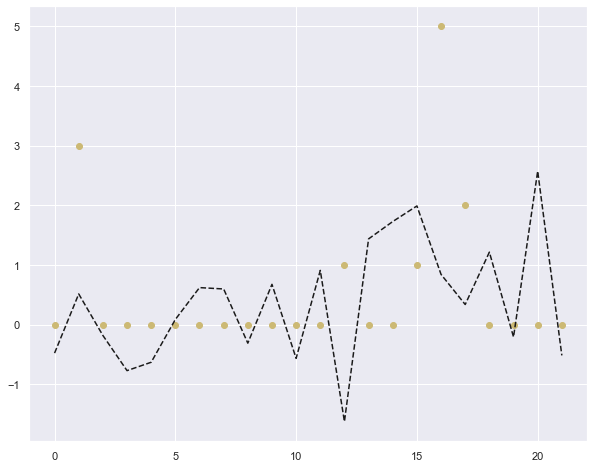

In [46]:
plt.plot([i for i in range(len(X_test))], y_test, 'yo', [i for i in range(len(X_test))], y_pred, '--k')

In [47]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [48]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [49]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [50]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............................model__alpha=0.1; total time=   0.1s
[CV 2/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.1; total time=   0.0s
[CV 1/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 2/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 3/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 4/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 5/5] END ...............................model__alpha=0.2; total time=   0.0s
[CV 1/5] END ...............model__alpha=0.30000000000000004; total time=   0.0s
[CV 2/5] END ...............model__alpha=0.3000

[CV 5/5] END ...............................model__alpha=2.2; total time=   0.0s
[CV 1/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 2/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 3/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 4/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 5/5] END ................model__alpha=2.3000000000000003; total time=   0.0s
[CV 1/5] END ................model__alpha=2.4000000000000004; total time=   0.0s
[CV 2/5] END ................model__alpha=2.4000000000000004; total time=   0.0s
[CV 3/5] END ................model__alpha=2.4000000000000004; total time=   0.0s
[CV 4/5] END ................model__alpha=2.4000000000000004; total time=   0.0s
[CV 5/5] END ................model__alpha=2.4000000000000004; total time=   0.0s
[CV 1/5] END ................model__alpha=2.5000000000000004; total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ...............................model__alpha=4.5; total time=   0.0s
[CV 1/5] END ...............................model__alpha=4.6; total time=   0.0s
[CV 2/5] END ...............................model__alpha=4.6; total time=   0.0s
[CV 3/5] END ...............................model__alpha=4.6; total time=   0.0s
[CV 4/5] END ...............................model__alpha=4.6; total time=   0.0s
[CV 5/5] END ...............................model__alpha=4.6; total time=   0.0s
[CV 1/5] END ...............................model__alpha=4.7; total time=   0.0s
[CV 2/5] END ...............................model__alpha=4.7; total time=   0.0s
[CV 3/5] END ...............................model__alpha=4.7; total time=   0.0s
[CV 4/5] END ...............................model__alpha=4.7; total time=   0.0s
[CV 5/5] END ...............................model__alpha=4.7; total time=   0.0s
[CV 1/5] END ...............................model__alpha=4.8; total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ...............................model__alpha=7.3; total time=   0.0s
[CV 1/5] END ...............................model__alpha=7.4; total time=   0.0s
[CV 2/5] END ...............................model__alpha=7.4; total time=   0.0s
[CV 3/5] END ...............................model__alpha=7.4; total time=   0.0s
[CV 4/5] END ...............................model__alpha=7.4; total time=   0.0s
[CV 5/5] END ...............................model__alpha=7.4; total time=   0.0s
[CV 1/5] END ...............................model__alpha=7.5; total time=   0.0s
[CV 2/5] END ...............................model__alpha=7.5; total time=   0.0s
[CV 3/5] END ...............................model__alpha=7.5; total time=   0.0s
[CV 4/5] END ...............................model__alpha=7.5; total time=   0.0s
[CV 5/5] END ...............................model__alpha=7.5; total time=   0.0s
[CV 1/5] END ...............................model__alpha=7.6; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ...............................model__alpha=9.6; total time=   0.0s
[CV 3/5] END ...............................model__alpha=9.6; total time=   0.0s
[CV 4/5] END ...............................model__alpha=9.6; total time=   0.0s
[CV 5/5] END ...............................model__alpha=9.6; total time=   0.0s
[CV 1/5] END .................model__alpha=9.700000000000001; total time=   0.0s
[CV 2/5] END .................model__alpha=9.700000000000001; total time=   0.0s
[CV 3/5] END .................model__alpha=9.700000000000001; total time=   0.0s
[CV 4/5] END .................model__alpha=9.700000000000001; total time=   0.0s
[CV 5/5] END .................model__alpha=9.700000000000001; total time=   0.0s
[CV 1/5] END ...............................model__alpha=9.8; total time=   0.0s
[CV 2/5] END ...............................model__alpha=9.8; total time=   0.0s
[CV 3/5] END ...............................model__alpha=9.8; total time=   0.0s
[CV 4/5] END ...............

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [51]:
search.best_params_

{'model__alpha': 0.1}

In [52]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [53]:
importance = np.abs(coefficients)

In [54]:
importance

array([0.        , 0.        , 0.        , 0.10434735, 0.14881675,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05929074, 0.        , 0.        , 0.        , 0.        ,
       0.50197327, 0.        , 0.        , 0.0191702 , 0.        ,
       0.        , 0.10628301, 0.        , 0.03494506, 0.15030257,
       0.        , 0.        , 0.        , 0.        , 0.03388258,
       0.05236192, 0.16739215, 0.2670385 ])

In [55]:
features = ['routes amount', 'approach, min', 'N', 'E', 'S', 'W',
       '<5a', '5a', '5b', '5c', '6a', '6b', '6c', '7a', '7b',
       '7c', '8a', '8b', '8c', '>8c', 'parking', 'overhang', 'roof',
       'vertical', 'slab', 'porphyr', 'limestone', 'family-friendly', 'safety',
       'height min', 'height max', 'rain safe', 'rating']

In [56]:
np.array(features)[importance > 0]

array(['E', 'S', '6a', '7c', '8c', 'overhang', 'vertical', 'slab',
       'height min', 'height max', 'rain safe', 'rating'], dtype='<U15')

In [57]:
np.array(features)[importance == 0]

array(['routes amount', 'approach, min', 'N', 'W', '<5a', '5a', '5b',
       '5c', '6b', '6c', '7a', '7b', '8a', '8b', '>8c', 'parking', 'roof',
       'porphyr', 'limestone', 'family-friendly', 'safety'], dtype='<U15')

In [59]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

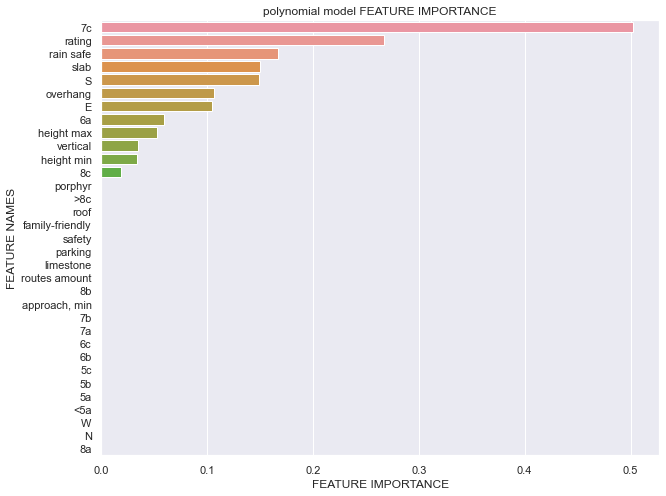

In [61]:
plot_feature_importance(importance, features,'polynomial model ')